Running experiments...
Matrix size: 100×100, Rank: 20
Sketch sizes: [5, 10, 15, 20, 25, 30, 40]
Condition numbers: 20 values from 1.0 to 10000.0
Progress: 0/20 condition numbers processed
Progress: 5/20 condition numbers processed
Progress: 10/20 condition numbers processed
Progress: 15/20 condition numbers processed
Experiments complete! Generating plots...


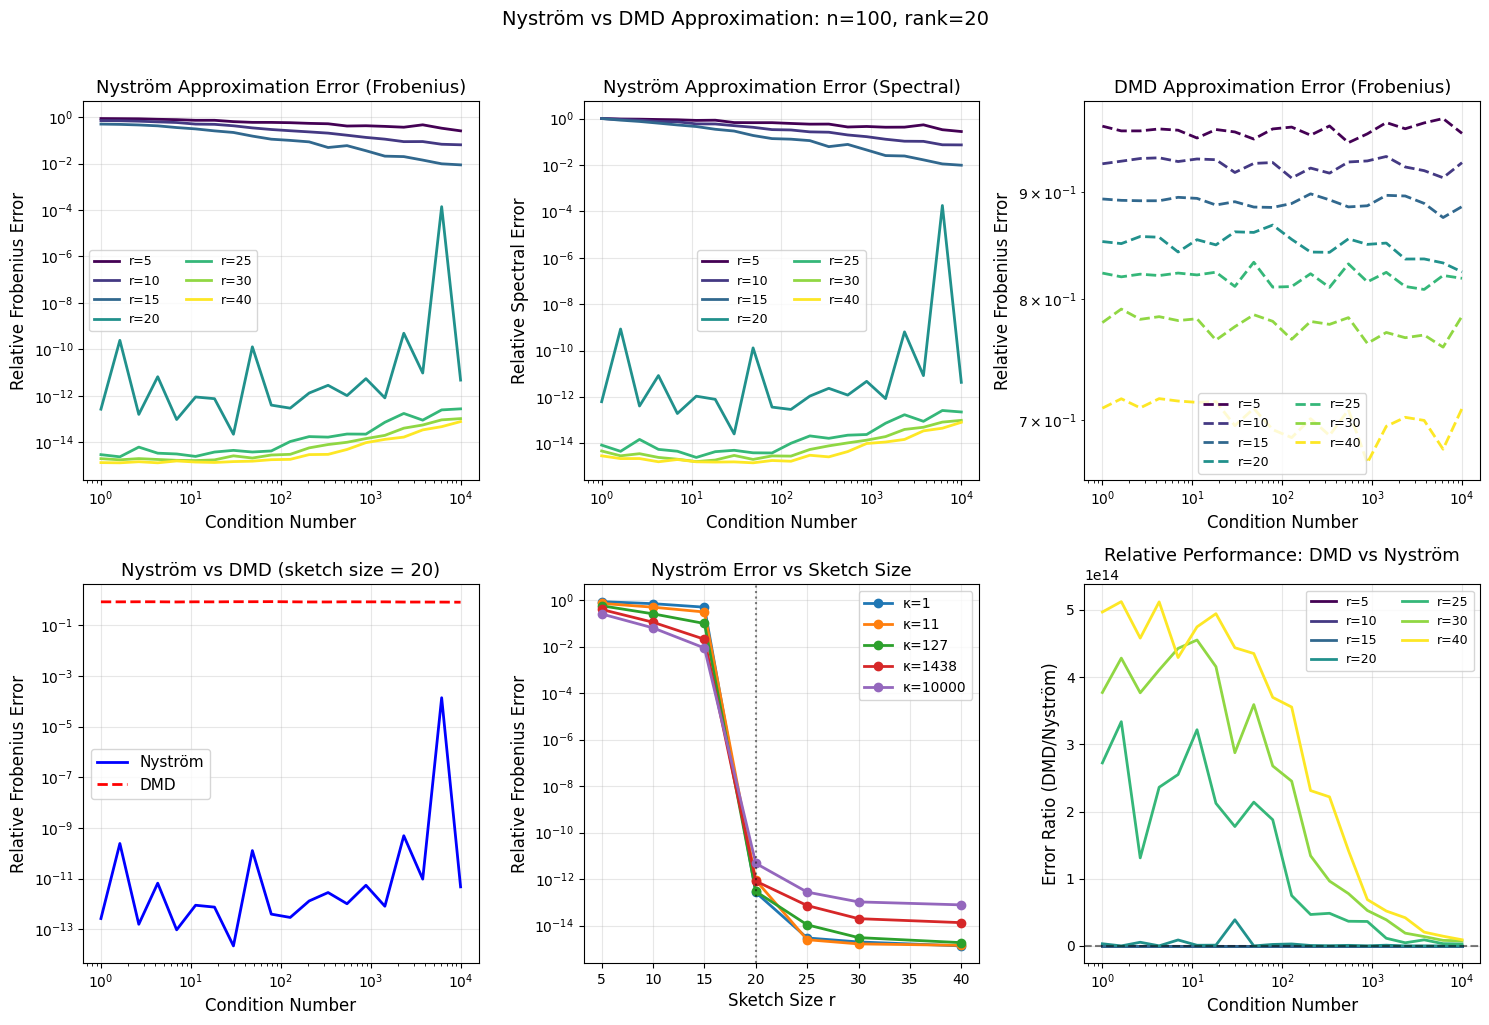


SUMMARY STATISTICS

When sketch size = true rank (20):
  Condition Number = 1:
    Nyström error: 2.65e-13
    DMD error: 8.52e-01
  Condition Number = 10000:
    Nyström error: 4.73e-12
    DMD error: 8.24e-01

At highest condition number (10000):
  Best sketch size for Nyström: 40 (error: 7.74e-14)
  Best sketch size for DMD: 40 (error: 7.09e-01)

Nyström achieves near-perfect reconstruction (error < 1e-10):
  In 76 cases
  Minimum sketch size needed: 20


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import svd, pinv
import warnings
warnings.filterwarnings('ignore')

def create_spsd_matrix(n, rank, condition_number, rng):
    """
    Create a random SPSD matrix with specified rank and condition number.
    
    Parameters:
    - n: dimension of the matrix
    - rank: rank of the matrix
    - condition_number: ratio of largest to smallest nonzero eigenvalue
    - rng: random number generator
    """
    # Create random orthogonal matrix
    Q, _ = np.linalg.qr(rng.standard_normal((n, n)))
    
    # Create eigenvalues with specified condition number
    # Logarithmically spaced eigenvalues from 1 to 1/condition_number
    eigvals = np.zeros(n)
    if rank > 0:
        eigvals[:rank] = np.logspace(0, -np.log10(condition_number), rank)
    
    # Create SPSD matrix
    A = Q @ np.diag(eigvals) @ Q.T
    
    # Ensure numerical symmetry
    A = (A + A.T) / 2
    
    return A, eigvals[:rank]

def nystrom_approximation(A, X):
    """
    Compute Nyström approximation of A using sketch X.
    Approximation: Ã = (AX)(X^T A X)^+ (AX)^T
    """
    AX = A @ X
    XTAX = X.T @ AX
    
    # Compute pseudoinverse with numerical stability
    try:
        XTAX_pinv = pinv(XTAX, rcond=1e-10)
    except:
        XTAX_pinv = pinv(XTAX)
    
    A_nystrom = AX @ XTAX_pinv @ AX.T
    
    # Ensure symmetry
    A_nystrom = (A_nystrom + A_nystrom.T) / 2
    
    return A_nystrom

def dmd_approximation(A, X):
    """
    Compute DMD-style approximation of A using sketch X.
    This computes A ≈ Y X^+ where Y = AX
    """
    Y = A @ X  # Y = AX
    
    # Compute X^+ (pseudoinverse of X)
    X_pinv = pinv(X, rcond=1e-10)
    
    # DMD approximation: A ≈ Y X^+
    A_dmd = Y @ X_pinv
    
    # For symmetric matrices, we can symmetrize the result
    A_dmd = (A_dmd + A_dmd.T) / 2
    
    return A_dmd

def compute_approximation_error(A, A_approx, norm_type='fro'):
    """
    Compute relative approximation error.
    """
    if norm_type == 'fro':
        error = np.linalg.norm(A - A_approx, 'fro') / np.linalg.norm(A, 'fro')
    elif norm_type == '2':
        error = np.linalg.norm(A - A_approx, 2) / np.linalg.norm(A, 2)
    else:
        raise ValueError("norm_type must be 'fro' or '2'")
    
    return error

# Set parameters
n = 100  # Matrix dimension
matrix_rank = 20  # Rank of the matrix
sketch_sizes = [5, 10, 15, 20, 25, 30, 40]  # Different sketch sizes to test
condition_numbers = np.logspace(0, 4, 20)  # From 1 to 10,000
num_trials = 5  # Number of trials for averaging

# Initialize storage for results
nystrom_errors_fro = np.zeros((len(condition_numbers), len(sketch_sizes)))
dmd_errors_fro = np.zeros((len(condition_numbers), len(sketch_sizes)))
nystrom_errors_2 = np.zeros((len(condition_numbers), len(sketch_sizes)))
dmd_errors_2 = np.zeros((len(condition_numbers), len(sketch_sizes)))

print("Running experiments...")
print(f"Matrix size: {n}×{n}, Rank: {matrix_rank}")
print(f"Sketch sizes: {sketch_sizes}")
print(f"Condition numbers: {len(condition_numbers)} values from {condition_numbers[0]:.1f} to {condition_numbers[-1]:.1f}")

# Run experiments
for i, cond_num in enumerate(condition_numbers):
    if i % 5 == 0:
        print(f"Progress: {i}/{len(condition_numbers)} condition numbers processed")
    
    for j, sketch_size in enumerate(sketch_sizes):
        # Average over multiple trials
        nystrom_fro_temp = []
        dmd_fro_temp = []
        nystrom_2_temp = []
        dmd_2_temp = []
        
        for trial in range(num_trials):
            rng = np.random.default_rng(42 + trial + i*100 + j*1000)
            
            # Create SPSD matrix with specified condition number
            A, eigvals = create_spsd_matrix(n, matrix_rank, cond_num, rng)
            
            # Create Gaussian sketch
            X = rng.standard_normal((n, sketch_size))
            X, _ = np.linalg.qr(X)  # Orthonormalize for stability
            
            # Compute approximations
            A_nystrom = nystrom_approximation(A, X)
            A_dmd = dmd_approximation(A, X)
            
            # Compute errors
            nystrom_fro_temp.append(compute_approximation_error(A, A_nystrom, 'fro'))
            dmd_fro_temp.append(compute_approximation_error(A, A_dmd, 'fro'))
            nystrom_2_temp.append(compute_approximation_error(A, A_nystrom, '2'))
            dmd_2_temp.append(compute_approximation_error(A, A_dmd, '2'))
        
        # Store average errors
        nystrom_errors_fro[i, j] = np.mean(nystrom_fro_temp)
        dmd_errors_fro[i, j] = np.mean(dmd_fro_temp)
        nystrom_errors_2[i, j] = np.mean(nystrom_2_temp)
        dmd_errors_2[i, j] = np.mean(dmd_2_temp)

print("Experiments complete! Generating plots...")

# Create comprehensive visualization
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Colors for different sketch sizes
colors = plt.cm.viridis(np.linspace(0, 1, len(sketch_sizes)))

# Plot 1: Frobenius norm error vs condition number
ax = axes[0, 0]
for j, sketch_size in enumerate(sketch_sizes):
    ax.loglog(condition_numbers, nystrom_errors_fro[:, j], '-', 
              color=colors[j], label=f'r={sketch_size}', linewidth=2)
ax.set_xlabel('Condition Number', fontsize=12)
ax.set_ylabel('Relative Frobenius Error', fontsize=12)
ax.set_title('Nyström Approximation Error (Frobenius)', fontsize=13)
ax.grid(True, alpha=0.3)
ax.legend(fontsize=9, ncol=2)

# Plot 2: Spectral norm error vs condition number
ax = axes[0, 1]
for j, sketch_size in enumerate(sketch_sizes):
    ax.loglog(condition_numbers, nystrom_errors_2[:, j], '-', 
              color=colors[j], label=f'r={sketch_size}', linewidth=2)
ax.set_xlabel('Condition Number', fontsize=12)
ax.set_ylabel('Relative Spectral Error', fontsize=12)
ax.set_title('Nyström Approximation Error (Spectral)', fontsize=13)
ax.grid(True, alpha=0.3)
ax.legend(fontsize=9, ncol=2)

# Plot 3: DMD Frobenius norm error
ax = axes[0, 2]
for j, sketch_size in enumerate(sketch_sizes):
    ax.loglog(condition_numbers, dmd_errors_fro[:, j], '--', 
              color=colors[j], label=f'r={sketch_size}', linewidth=2)
ax.set_xlabel('Condition Number', fontsize=12)
ax.set_ylabel('Relative Frobenius Error', fontsize=12)
ax.set_title('DMD Approximation Error (Frobenius)', fontsize=13)
ax.grid(True, alpha=0.3)
ax.legend(fontsize=9, ncol=2)

# Plot 4: Comparison at fixed sketch size (Frobenius)
ax = axes[1, 0]
sketch_idx = 3  # Use sketch_size = 20 (same as rank)
ax.loglog(condition_numbers, nystrom_errors_fro[:, sketch_idx], 'b-', 
          label='Nyström', linewidth=2)
ax.loglog(condition_numbers, dmd_errors_fro[:, sketch_idx], 'r--', 
          label='DMD', linewidth=2)
ax.set_xlabel('Condition Number', fontsize=12)
ax.set_ylabel('Relative Frobenius Error', fontsize=12)
ax.set_title(f'Nyström vs DMD (sketch size = {sketch_sizes[sketch_idx]})', fontsize=13)
ax.grid(True, alpha=0.3)
ax.legend(fontsize=11)

# Plot 5: Error vs sketch size for different condition numbers
ax = axes[1, 1]
cond_indices = [0, 5, 10, 15, 19]  # Select a few condition numbers
for idx in cond_indices:
    ax.semilogy(sketch_sizes, nystrom_errors_fro[idx, :], 'o-', 
                label=f'κ={condition_numbers[idx]:.0f}', linewidth=2)
ax.set_xlabel('Sketch Size r', fontsize=12)
ax.set_ylabel('Relative Frobenius Error', fontsize=12)
ax.set_title('Nyström Error vs Sketch Size', fontsize=13)
ax.grid(True, alpha=0.3)
ax.legend(fontsize=10)
ax.axvline(x=matrix_rank, color='k', linestyle=':', alpha=0.5, 
           label=f'True rank={matrix_rank}')

# Plot 6: Ratio of errors (DMD/Nyström)
ax = axes[1, 2]
for j, sketch_size in enumerate(sketch_sizes):
    ratio = dmd_errors_fro[:, j] / (nystrom_errors_fro[:, j] + 1e-16)
    ax.semilogx(condition_numbers, ratio, '-', color=colors[j], 
                label=f'r={sketch_size}', linewidth=2)
ax.axhline(y=1, color='k', linestyle='--', alpha=0.5)
ax.set_xlabel('Condition Number', fontsize=12)
ax.set_ylabel('Error Ratio (DMD/Nyström)', fontsize=12)
ax.set_title('Relative Performance: DMD vs Nyström', fontsize=13)
ax.grid(True, alpha=0.3)
ax.legend(fontsize=9, ncol=2)

plt.suptitle(f'Nyström vs DMD Approximation: n={n}, rank={matrix_rank}', 
             fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# Print summary statistics
print("\n" + "="*60)
print("SUMMARY STATISTICS")
print("="*60)

# When sketch size equals true rank
sketch_equals_rank_idx = sketch_sizes.index(matrix_rank) if matrix_rank in sketch_sizes else -1
if sketch_equals_rank_idx >= 0:
    print(f"\nWhen sketch size = true rank ({matrix_rank}):")
    print(f"  Condition Number = 1:")
    print(f"    Nyström error: {nystrom_errors_fro[0, sketch_equals_rank_idx]:.2e}")
    print(f"    DMD error: {dmd_errors_fro[0, sketch_equals_rank_idx]:.2e}")
    print(f"  Condition Number = 10000:")
    print(f"    Nyström error: {nystrom_errors_fro[-1, sketch_equals_rank_idx]:.2e}")
    print(f"    DMD error: {dmd_errors_fro[-1, sketch_equals_rank_idx]:.2e}")

# Best sketch size for each method at highest condition number
best_nystrom_idx = np.argmin(nystrom_errors_fro[-1, :])
best_dmd_idx = np.argmin(dmd_errors_fro[-1, :])
print(f"\nAt highest condition number ({condition_numbers[-1]:.0f}):")
print(f"  Best sketch size for Nyström: {sketch_sizes[best_nystrom_idx]} (error: {nystrom_errors_fro[-1, best_nystrom_idx]:.2e})")
print(f"  Best sketch size for DMD: {sketch_sizes[best_dmd_idx]} (error: {dmd_errors_fro[-1, best_dmd_idx]:.2e})")

# Check if perfect reconstruction occurs
perfect_threshold = 1e-10
perfect_nystrom = np.where(nystrom_errors_fro < perfect_threshold)
perfect_dmd = np.where(dmd_errors_fro < perfect_threshold)

if len(perfect_nystrom[0]) > 0:
    print(f"\nNyström achieves near-perfect reconstruction (error < {perfect_threshold}):")
    print(f"  In {len(perfect_nystrom[0])} cases")
    print(f"  Minimum sketch size needed: {min(sketch_sizes[j] for j in perfect_nystrom[1])}")

if len(perfect_dmd[0]) > 0:
    print(f"\nDMD achieves near-perfect reconstruction (error < {perfect_threshold}):")
    print(f"  In {len(perfect_dmd[0])} cases")
    print(f"  Minimum sketch size needed: {min(sketch_sizes[j] for j in perfect_dmd[1])}")